<a href="https://colab.research.google.com/github/aykq/internship/blob/main/tensorflow/05_Transfer_Learning_with_TensorFlow_Part_3_Scaling_up_(Food_Vision_mini).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 05 - Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

In the previous two notebooks ([transfer learning part 1: feature extraction](https://github.com/aykq/internship/blob/main/tensorflow/03_Transfer_Learning_with_TensorFlow_Part_1_Feature_Extraction.ipynb) and [part 2: fine-tuning](https://github.com/aykq/internship/blob/main/tensorflow/04_Transfer_Learning_with_TensorFlow_Part_2_Fine_tuning.ipynb)) we've seen the power of transfer learning.

Now we know our smaller modelling experiments are working, it's time to step things up a notch with more data.

This is a common practice in machine learning and deep learning: get a model working on a small amount of data before scaling it up to a larger amount of data.

**Note:** You haven't forgotten the machine learning practitioners motto have you? "Experiment, experiment, experiment."

It's time to get closer to our Food Vision project coming to life. In this notebook we're going to scale up from using 10 classes of the Food101 data to using all of the classes in the Food101 dataset.

**Our goal is to beat the original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf)'s results with 10% of data.**

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-ml-serial-experimentation.png)
*Machine learning practitioners are seriel experimenters. Start small, get a model working, see if your experiments work then gradually scale them up where you want to go (we're going to be looking at scaling up throughout this notebook).*

---
# What we're going to cover

We're going to go through the follow with TensorFlow:

+ Downloading and preparing 10% of the Food101 data (10% of training data)
+ Training a feature extraction transfer learning model on 10% of the Food101 training data
+ Fine-tuning our feature extraction model
+ Saving and loaded our trained model
+ Evaluating the performance of our Food Vision model trained on 10% of the training data
  + Finding our model's most wrong predictions
+ Making predictions with our Food Vision model on custom images of food


In [2]:
# are we using a GPU?
# if not, and you're in Google Colab, go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
!nvidia-smi

Tue Jul 18 12:55:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

---
# Creating helper functions

We've created a series of helper functions throughout the previous notebooks. Instead of rewriting them (tedious), we'll import the `helper_functions.py` file from GitHub page.

In [3]:
# get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-07-18 12:55:12--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-18 12:55:12 (106 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

---
# 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original [Food101](https://www.kaggle.com/dansbecker/food-101) dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test images.



---
# Downloading and preprocessing the data

Just as before we'll download a subset of the Food101 dataset which has been extracted from the original dataset (to see the preprocessing of the data check out the [Food Vision preprocessing notebook](https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb)).

We download the data as a zip file so we'll use our `unzip_data()` function to unzip it.

In [5]:
# dowwnload data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-07-18 12:55:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  39.4MB/s    in 40s     

2023-07-18 12:55:56 (38.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [6]:
# how many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/pulled_pork_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lasagna'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/lobster_bisque'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/club_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/beef_carpaccio'.
There are

As before our data comes in the common image classification data format of:

```
Example of file structure

10_food_classes_10_percent <- top level folder
└───train <- training images
│   └───pizza
│   │   │   1008104.jpg
│   │   │   1638227.jpg
│   │   │   ...      
│   └───steak
│       │   1000205.jpg
│       │   1647351.jpg
│       │   ...
│   
└───test <- testing images
│   └───pizza
│   │   │   1001116.jpg
│   │   │   1507019.jpg
│   │   │   ...      
│   └───steak
│       │   100274.jpg
│       │   1653815.jpg
│       │   ...    

```

Let's use the `image_dataset_from_directory()` function to turn our images and labels into a `tf.data.Dataset`, a TensorFlow datatype which allows for us to pass it directory to our model.

For the test dataset, we're going to set shuffle=False so we can perform repeatable evaluation and visualization on it later.

In [7]:
# setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


It looks like our data has been imported as expected with 75 images per class in the training set (75 images * 101 classes = 7575 images) and 25250 images in the test set (250 images * 101 classes = 25250 images).

---
# Train a big dog model with transfer learning on 10% of 101 food classes

Our food image data has been imported into TensorFlow, time to model it.

To keep our experiments swift, we're going to start by using feature extraction transfer learning with a pre-trained model for a few epochs and then fine-tune for a few more epochs.

More specifically, our goal will be to see if we can beat the baseline from original [Food101 paper](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf) (50.76% accuracy on 101 classes) with 10% of the training data and the following modelling setup:

+ A `ModelCheckpoint` callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time
+ Data augmentation built right into the model
+ A headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model
+ A `Dense` layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer
+ Categorical crossentropy as the loss function since we're dealing with more than two classes
+ The Adam optimizer with the default settings
+ Fitting for 5 full passes on the training data while evaluating on 15% of the test data

It seems like a lot but these are all things we've covered before in the [Transfer Learning in TensorFlow Part 2: Fine-tuning notebook](https://github.com/aykq/internship/blob/main/tensorflow/04_Transfer_Learning_with_TensorFlow_Part_2_Fine_tuning.ipynb).

Let's start by creating the `ModelCheckpoint` callback.

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.



In [8]:
# create checkpoint callback to save model for later use
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

Checkpoint ready. Now let's create a small data augmentation model with the Sequential API. Because we're working with a reduced sized training set, this will help prevent our model from overfitting on the training data.

In [9]:
# import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## NEW: Newer versions of TensorFlow (2.10+) can use the tensorflow.keras.layers API directly for data augmentation
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

## OLD
# # Setup data augmentation
# from tensorflow.keras.layers.experimental import preprocessing
# data_augmentation = Sequential([
#   preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
#   preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
#   preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
#   preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
#   preprocessing.RandomZoom(0.2), # randomly zoom into an image
#   # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
# ], name="data_augmentation")

We'll be able to insert the `data_augmentation` Sequential model as a layer in our Functional API model. That way if we want to continue training our model at a later time, the data augmentation is already built right in.

Speaking of Functional API model's, time to put together a feature extraction transfer learning model using `tf.keras.applications.efficientnet.EfficientNetB0` as our base model.

We'll import the base model using the parameter `include_top=False` so we can add on our own output layers, notably `GlobalAveragePooling2D()` (condense the outputs of the base model into a shape usable by the output layer) followed by a Dense layer.



In [10]:
# setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable = False

# setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data_all_10_percent.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-efficientnetb0-feature-extractor-with-dense-layer-on-top.png)

*A colourful figure of the model we've created with: 224x224 images as input, data augmentation as a layer, EfficientNetB0 as a backbone, an averaging pooling layer as well as dense layer with 10 neurons (same as number of classes we're working with) as output.*

Model created. Let's inspect it.

In [11]:
# get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

Looking good! Our Functional model has 5 layers but each of those layers have varying amounts of layers within them.

Notice the number of trainable and non-trainable parameters. It seems the only trainable parameters are within the `output_layer` which is exactly what we're after with this first run of feature extraction; keep all the learned patterns in the base model `(EfficientNetb0)` frozen whilst allowing the model to tune its outputs to our custom data.

Time to compile and fit.

In [12]:
# compile
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(), # use Adam with default settings
              metrics=["accuracy"])

# fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5, # fit for 5 epochs to keep experiments quick
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)), # evaluate on smaller portion of test data
                                           callbacks=[checkpoint_callback]) # save best model weights to file

Epoch 1/5
237/237 [==============================] - 125s 458ms/step - loss: 3.3796 - accuracy: 0.2706 - val_loss: 2.4302 - val_accuracy: 0.4772
Epoch 2/5
237/237 [==============================] - 75s 312ms/step - loss: 2.1967 - accuracy: 0.5024 - val_loss: 2.0127 - val_accuracy: 0.5140
Epoch 3/5
237/237 [==============================] - 66s 275ms/step - loss: 1.8236 - accuracy: 0.5678 - val_loss: 1.8070 - val_accuracy: 0.5437
Epoch 4/5
237/237 [==============================] - 64s 268ms/step - loss: 1.5993 - accuracy: 0.6143 - val_loss: 1.7451 - val_accuracy: 0.5524
Epoch 5/5
237/237 [==============================] - 59s 244ms/step - loss: 1.4529 - accuracy: 0.6451 - val_loss: 1.7007 - val_accuracy: 0.5564


It looks like our model is getting some impressive results, but remember, during training our model only evaluated on 15% of the test data. Let's see how it did on the whole test dataset.



In [13]:
# evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 61s 77ms/step - loss: 1.5878 - accuracy: 0.5810


[1.5878167152404785, 0.5809504985809326]

Well it looks like **we just beat our baseline (the results from the original Food101 paper) with 10% of the data!** In under 5-minutes... that's the power of deep learning and more precisely, transfer learning: leveraging what one model has learned on another dataset for our own dataset.

How do the loss curves look?

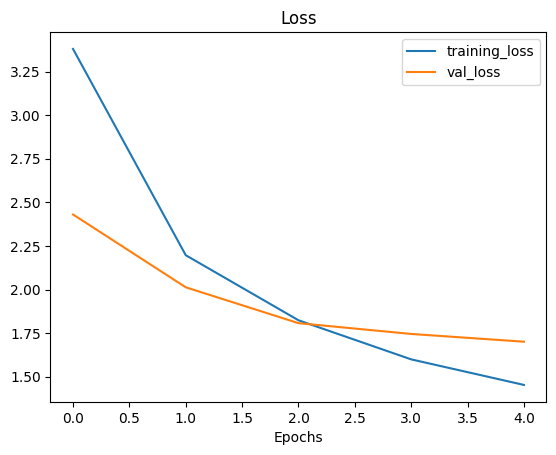

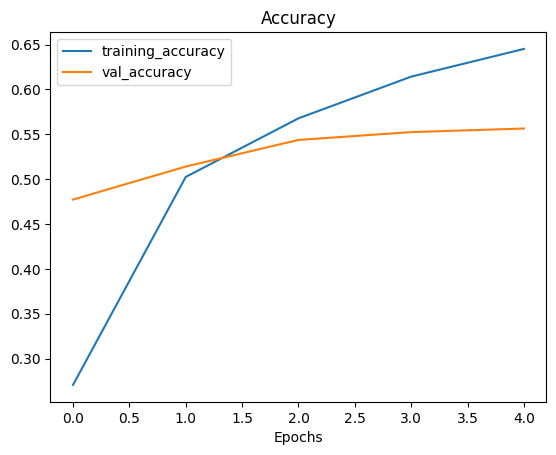

In [14]:
plot_loss_curves(history_all_classes_10_percent)

**Question:** What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not, there may be some overfitting or underfitting.



---
## Fine-tuning

Our feature extraction transfer learning model is performing well. Why don't we try to fine-tune a few layers in the base model and see if we gain any improvements?

The good news is, thanks to the ModelCheckpoint callback, we've got the saved weights of our already well-performing model so if fine-tuning doesn't add any benefits, we can revert back.

To fine-tune the base model we'll first set its trainable attribute to True, unfreezing all of the frozen.

Then since we've got a relatively small training dataset, we'll refreeze every layer except for the last 5, making them trainable.

In [15]:
# unfreeze all of the layers in the base model
base_model.trainable = True

# refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

We just made a change to the layers in our model and what do we have to do every time we make a change to our model?

Recompile it.

Because we're fine-tuning, we'll use a 10x lower learning rate to ensure the updates to the previous trained weights aren't too large.

![](https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/06-lowering-the-learning-rate.png)

*When fine-tuning and unfreezing layers of your pre-trained model, it's common practice to lower the learning rate you used for your feature extraction model. How much by? A 10x lower learning rate is usually a good place to to start.*

In [16]:
# recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

Model recompiled, how about we make sure the layers we want are trainable?

In [17]:
# what layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [18]:
# check which layers are trainable
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

Excellent! Time to fine-tune our model.

Another 5 epochs should be enough to see whether any benefits come about (though we could always try more).

We'll start the training off where the feature extraction model left off using the `initial_epoch` parameter in the `fit()` function.

In [19]:
# fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 72s 258ms/step - loss: 1.2067 - accuracy: 0.6821 - val_loss: 1.6841 - val_accuracy: 0.5569
Epoch 6/10
237/237 [==============================] - 52s 219ms/step - loss: 1.0816 - accuracy: 0.7079 - val_loss: 1.7077 - val_accuracy: 0.5508
Epoch 7/10
237/237 [==============================] - 50s 211ms/step - loss: 1.0176 - accuracy: 0.7317 - val_loss: 1.6773 - val_accuracy: 0.5556
Epoch 8/10
237/237 [==============================] - 46s 193ms/step - loss: 0.9463 - accuracy: 0.7526 - val_loss: 1.7084 - val_accuracy: 0.5519
Epoch 9/10
237/237 [==============================] - 48s 199ms/step - loss: 0.8841 - accuracy: 0.7649 - val_loss: 1.7141 - val_accuracy: 0.5522
Epoch 10/10
237/237 [==============================] - 45s 188ms/step - loss: 0.8335 - accuracy: 0.7757 - val_loss: 1.6944 - val_accuracy: 0.5538


Once again, during training we were only evaluating on a small portion of the test data, let's find out how our model went on all of the test data.



In [20]:
# evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 70s 89ms/step - loss: 1.5025 - accuracy: 0.6015


[1.5025362968444824, 0.601504921913147]

Hmm... it seems like our model got a slight boost from fine-tuning.

We might get a better picture by using our `compare_historys()` function and seeing what the training curves say.

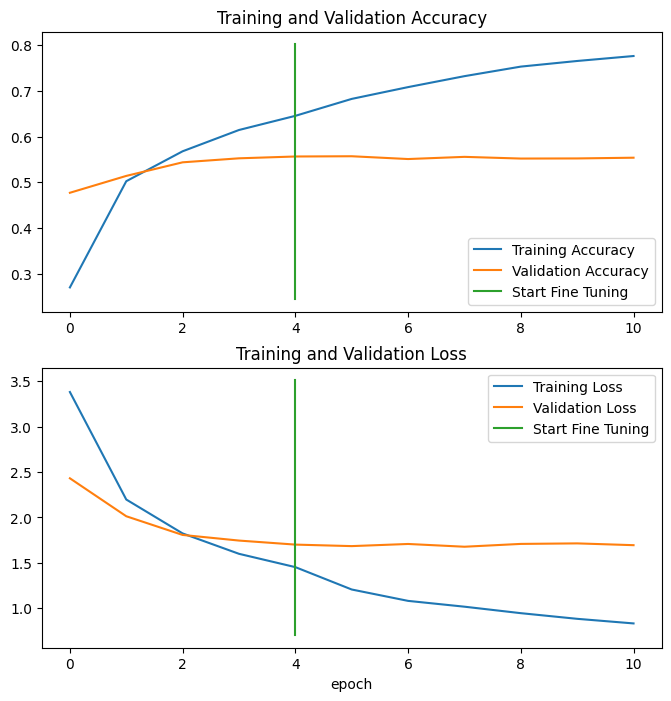

In [21]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

It seems that after fine-tuning, our model's training metrics improved significantly but validation, not so much. Looks like our model is starting to overfit.

This is okay though, its very often the case that fine-tuning leads to overfitting when the data a pre-trained model has been trained on is similar to your custom data.

In our case, our pre-trained model, `EfficientNetB0` was trained on [ImageNet](http://www.image-net.org/index) which contains many real life pictures of food just like our food dataset.

If feautre extraction already works well, the improvements you see from fine-tuning may not be as great as if your dataset was significantly different from the data your base model was pre-trained on.

